In [209]:
%pylab inline --no-import-all
import seaborn as sns
import scipy as sp
import scipy.ndimage
import os
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD

Populating the interactive namespace from numpy and matplotlib


Downloading MNIST datased

In [298]:
import requests
import gzip
from pathlib import Path

urls = [
    "http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz",
    "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"
]

paths = [
    "/tmp/train_images",
    "/tmp/train_labels",
    "/tmp/test_images",
    "/tmp/test_labels"
]

def check_exist(path_to_file):
    file = Path(path_to_file)
    return file.exists()

for path, url in zip(paths, urls):
    if not check_exist(path) or not os.path.getsize(path):
        print("downloading " + url)
        response = requests.get(url)
        with open(path, "wb") as f:
            print("writing to" + path)
            f.write(gzip.decompress(response.content))

Define some helper functions

In [286]:
import os, struct
from array import array

def read_mnist(digits, fname_img, fname_lbl):
    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    images =  np.zeros((len(ind), rows*cols))
    labels = np.zeros((len(ind), 1))
    for i in range(len(ind)):
        images[i, :] = list(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ])
        labels[i] = lbl[ind[i]]

    return images, labels


def decode_one_hot(encoded):
    return np.apply_along_axis(np.argmax, axis=1, arr=encoded)

def evaluate_accuracy(predicted, expected): 
    return ("model accuracy on test data: {:.3f}%"
            .format(100 * (1.0 - (predicted != expected).sum() / expected.shape[0])) )

Read MNIST dataset and convert result to numpy arrays

In [152]:
train_images, train_labels = read_mnist(list(range(0, 10)), paths[0], paths[1])
test_images, test_labels = read_mnist(list(range(0, 10)), paths[2], paths[3])
images = np.vstack((train_images, test_images))  # put it together for similar filtering
labels = np.vstack((train_labels, test_labels))

Split data to train and test sets

In [266]:
trainX, testX = np.split(clean_images, [60000])
trainY, testY = np.split(labels.astype(int), [60000])
trainY = keras.utils.to_categorical(trainY, num_classes=10)

First let's create multiple layer perceptron

In [372]:
mlp_model = Sequential([
    Dense(128, input_shape=(784,)),
    Activation('relu'),
    Dropout(0.125),
    Dense(64),
    Activation('relu'),
    Dense(10),
    Activation('softmax'),
])

mlp_model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Training the model

In [373]:
mlp_model.fit(trainX, trainY, epochs=10, batch_size=30)

Epoch 1/10
60000/60000 [==============================] - 5s - loss: 0.3082 - acc: 0.9095     
Epoch 2/10
60000/60000 [==============================] - 4s - loss: 0.1544 - acc: 0.9540     
Epoch 3/10
60000/60000 [==============================] - 4s - loss: 0.1215 - acc: 0.9644     
Epoch 4/10
60000/60000 [==============================] - 4s - loss: 0.1032 - acc: 0.9706     
Epoch 5/10
60000/60000 [==============================] - 5s - loss: 0.0898 - acc: 0.9747     
Epoch 6/10
60000/60000 [==============================] - 4s - loss: 0.0853 - acc: 0.9775     
Epoch 7/10
60000/60000 [==============================] - 4s - loss: 0.0755 - acc: 0.9794     
Epoch 8/10
60000/60000 [==============================] - 4s - loss: 0.0724 - acc: 0.9811     
Epoch 9/10
60000/60000 [==============================] - 4s - loss: 0.0647 - acc: 0.9831     
Epoch 10/10
60000/60000 [==============================] - 4s - loss: 0.0618 - acc: 0.9840     


Predict output values for test samples and evaluate model accuracy

In [375]:
mlp_predictions = mlp_model.predict(testX)

decoded_mlp_predictions = decode_one_hot(mlp_predictions)
expected = testY.reshape(testY.shape[0])

print(evaluate_accuracy(decoded_mlp_predictions, expected))

model accuracy on test data: 97.020%


Now let's see how frequently certain digits were not recognized and what's was recognized instead 

In [362]:
import matplotlib.patches as mpatches

def error_plot(predictions, true):
    def what_is_predicted(predictions, instead_of):
        return predictions[np.all(
            (predictions != true, true == instead_of),
            axis=0)]

    fig, ax = plt.subplots(figsize=(14, 10), dpi=80)
    colors = [
        "#B76C6C",
        "#B78B6C",
        "#B3B76C",
        "#90B76C",
        "#6CB77E",
        "#6CB7B2",
        "#6C96B7",
        "#6C76B7",
        "#906CB7",
        "#B76CB5"
    ]
    plt.xticks(np.arange(10), size=16)
    plt.xlabel("What should be", size=20)
    plt.ylabel("Wrong predictions", size=20)


    wrong_numbers = [np.bincount(what_is_predicted(predictions, i)) for i in range(0, 10)]
    result = []
    for i, num in enumerate(wrong_numbers):
        bottom = 0
        for j, error in enumerate(num):
            if error:
                result.append(ax.bar(i, error, bottom=bottom, color=colors[j]))       
                ax.text(i, bottom + error*0.5 - 0.1, j,
                        verticalalignment='center',
                        horizontalalignment='center',
                        size=10, weight='bold')

                bottom += error

    ax.legend(handles = [mpatches.Patch(color=colors[i], label=i) for i in reversed(range(10))])

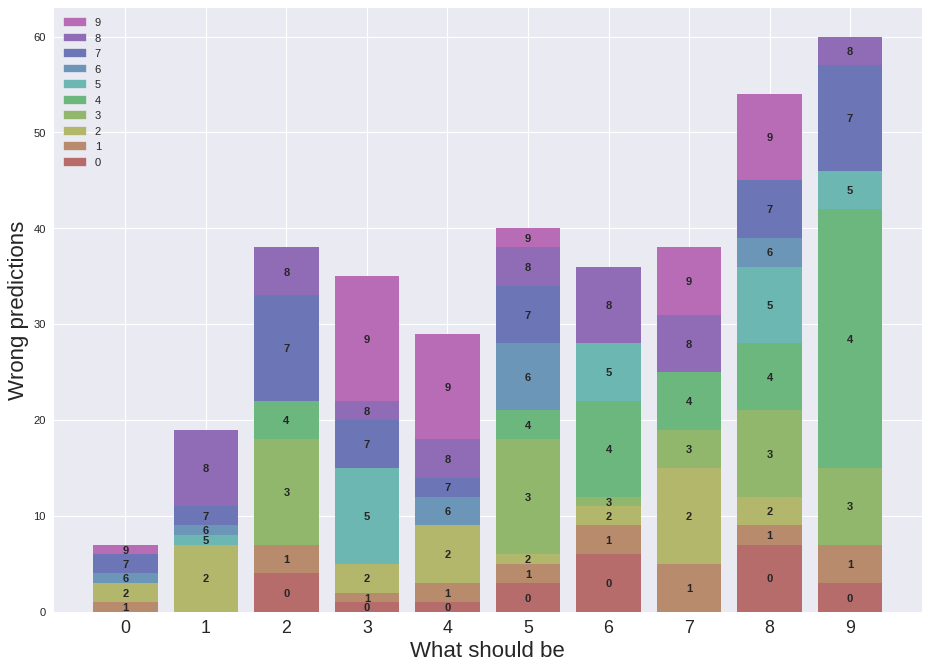

In [363]:
error_plot(decoded_mlp_predictions, expected)

Now we're going to create more complex network, with two convolution layers

In [386]:
cnn_model = Sequential([
    # input shape is (28, 28, 1), i.e. 28x28 pixels image with 1 color chanel (grayscale)
    Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.125),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
cnn_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In order to apply 2D convolution, we have to convert our train samples into (28, 28, 1) tensors

In [387]:
cnnTrainX = trainX.reshape(trainX.shape[0], 28, 28, 1)
cnnTestX = testX.reshape(testX.shape[0], 28, 28, 1)

In [389]:
cnn_model.fit(cnnTrainX, trainY, batch_size=30, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 37s - loss: 0.4027 - acc: 0.8733    
Epoch 2/10
60000/60000 [==============================] - 38s - loss: 0.2376 - acc: 0.9285    
Epoch 3/10
60000/60000 [==============================] - 37s - loss: 0.1844 - acc: 0.9448    
Epoch 4/10
60000/60000 [==============================] - 37s - loss: 0.1566 - acc: 0.9530    
Epoch 5/10
60000/60000 [==============================] - 37s - loss: 0.1416 - acc: 0.9568    
Epoch 6/10
60000/60000 [==============================] - 38s - loss: 0.1253 - acc: 0.9615    
Epoch 7/10
60000/60000 [==============================] - 37s - loss: 0.1175 - acc: 0.9648    
Epoch 8/10
60000/60000 [==============================] - 37s - loss: 0.1134 - acc: 0.9659    
Epoch 9/10
60000/60000 [==============================] - 37s - loss: 0.1037 - acc: 0.9693    
Epoch 10/10
60000/60000 [==============================] - 37s - loss: 0.0996 - acc: 0.9699    


Evaluating on test data

In [390]:
cnn_predictions = cnn_model.predict(cnnTestX)

decoded_cnn_predictions = decode_one_hot(cnn_predictions)
expected = testY.reshape(testY.shape[0])

print(evaluate_accuracy(decoded_cnn_predictions, expected))

model accuracy on test data: 98.390%


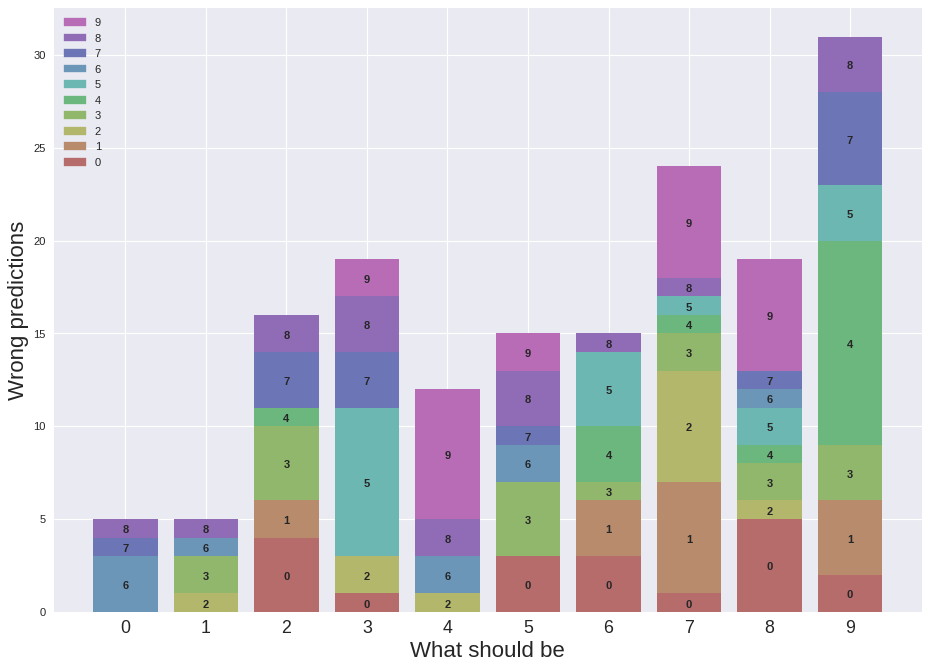

In [391]:
error_plot(decoded_cnn_predictions, expected)